#  TaiChung DE Plant PV Forecast SARIMA

Data from TaiChung DE PV plant.

Collect 2016/01/01-2017/12/31.

Time frequcy: 1 hour.

Try forcast.

In [1]:
# import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# quick look data
data = pd.read_csv('data\\power_no_outlier.csv', parse_dates=['Date'], index_col='Date', encoding='utf-8-sig')
print(data.head(12))
print(data.info())

                     power(KWH)  hour  power(KWH)_replaced
Date                                                      
2016-01-01 01:00:00         0.0     1                  0.0
2016-01-01 02:00:00         0.0     2                  0.0
2016-01-01 03:00:00         0.0     3                  0.0
2016-01-01 04:00:00         0.0     4                  0.0
2016-01-01 05:00:00         0.0     5                  0.0
2016-01-01 06:00:00         0.0     6                  0.0
2016-01-01 07:00:00         0.0     7                  0.0
2016-01-01 08:00:00       146.0     8                146.0
2016-01-01 09:00:00       444.0     9                444.0
2016-01-01 10:00:00       680.0    10                680.0
2016-01-01 11:00:00       892.0    11                892.0
2016-01-01 12:00:00       932.0    12                932.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 01:00:00 to 2018-01-01 00:00:00
Data columns (total 3 columns):
 #   Column               Non-N

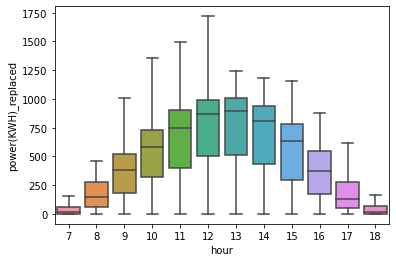

In [3]:
# choose time zone 7-18 . 
data_7_18 = data.between_time('7:00','18:00')
plt.figure()
sns.boxplot(x='hour',y='power(KWH)_replaced',data=data_7_18)
plt.show()

# Time series modeling framework

![title](image/time_series_modeling_framework.jpg)

* Test for stationarity and seasonality

* Find promising model orders

* Fit models and narrow selection with AIC/BIC

* Perform model diagnostics tests

* Make forecasts

* Save and update models

# Test for stationarity and seasonality

4 questions:
    
    1.Is the time series stationary?
    
    2.What differecing make it stationary?
    
    3.What transformers will make it stationary?
    
    4.What values of p and q are most promising?

Try Dicky-Fuller test.

Null hypothesis is non-stationary.

In [4]:
# Dicky-Fuller test
results = adfuller(data['power(KWH)_replaced'])
#Perform Dickey-Fuller test result:
print('Results of Dickey-Fuller Test:')
results_output = pd.Series(results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in results[4].items():
    results_output['Critical Value (%s)'%key] = value

print (results_output) 

Results of Dickey-Fuller Test:
Test Statistic                -1.203645e+01
p-value                        2.796122e-22
#Lags Used                     4.400000e+01
Number of Observations Used    1.749900e+04
Critical Value (1%)           -3.430724e+00
Critical Value (5%)           -2.861705e+00
Critical Value (10%)          -2.566858e+00
dtype: float64


Test statistic : -12.03644629189143 → more negative means more likely to be stationary.

P-value: 2.796121583625262e-22
    
If p-value is small → reject null hypothesis. Reject non-stationary.

Try take diff(1).


In [5]:
# take diff(1) and dropna
power_1 = data['power(KWH)_replaced'].diff(1).dropna()
# Dicky-Fuller test
results = adfuller(power_1)
#Perform Dickey-Fuller test result:
print('Results of Dickey-Fuller Test:')
results_output = pd.Series(results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in results[4].items():
    results_output['Critical Value (%s)'%key] = value

print (results_output) 

Results of Dickey-Fuller Test:
Test Statistic                   -34.273304
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17498.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


P-value = 0 . **The time series is stationary.**

time series = trend + seasonal + residual

Seasonal data has predictable and repeated patterns.

This is hourly data. period =24

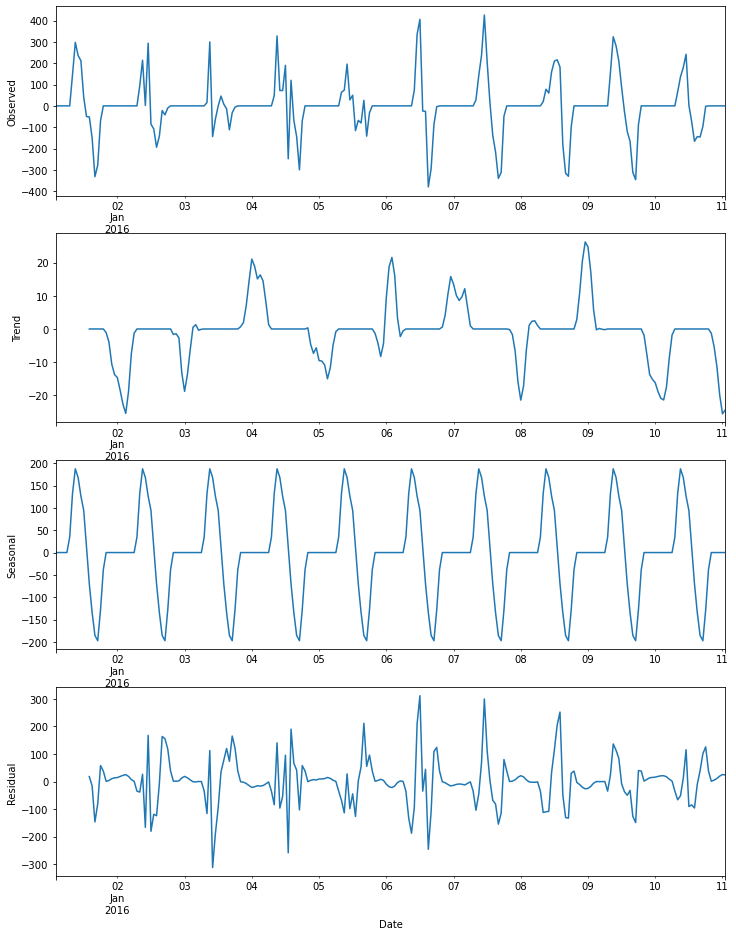

In [6]:
decomp_results = seasonal_decompose(power_1,period=24)
fig,(ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (12, 16))
decomp_results.observed[:240].plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
decomp_results.trend[:240].plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
decomp_results.seasonal[:240].plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
decomp_results.resid[:240].plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')

plt.show()


# Find promising model orders

Seasonal ARIMA = SARIMA

SARIMA(p,d,q)(P,D,Q,S)

* Non-seasonal orders
    
        p:autoregrassive order
    
        d:differencing order
    
        q:moving average order

* Seasonal orders
    
        P:Seasonal autoregrassive order
    
        D:Seasonal differencing order
    
        Q:Seasonal moving average order
    
        S:number of time steps per cycle
    

Plot the ACF and PACF charts and find the optimal parameters

ACF - Autocorrelation function.

PACF - Partial autocorrelation function.


Name|AR(P)              |MA(q)              |ARMA(p,q)
----|:-----------------:|:-----------------:|:----:
ACF |Tails off          |cut off after lag q|Tails off  
PACF|cut off after lag p|Tails off          |Tails off  



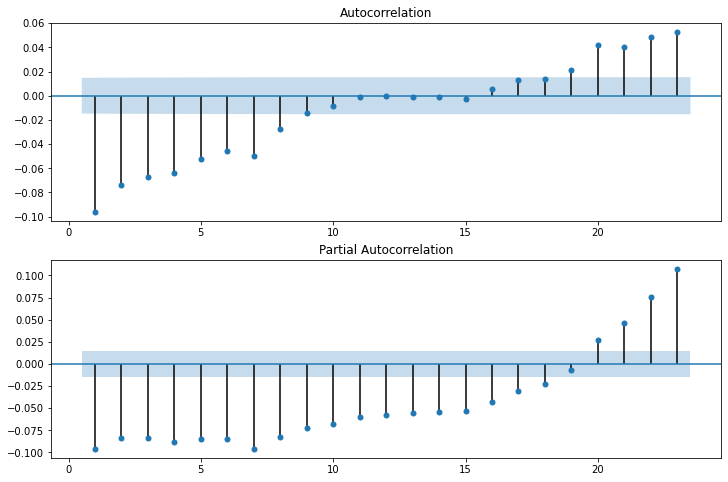

In [7]:
# Take the seasonal differences and drop NaNs
power_2 = power_1.diff(24).dropna()

# finding p,q
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# Make ACF plot up to 23
plot_acf(power_2, lags=23, zero=False, ax=ax1)
# Make PACF plot up to 23
plot_pacf(power_2, lags=23, zero=False, ax=ax2)
plt.show()

ACF :not tails off and cut off
    
PACF:not tails off and cut off
    
$\therefore p = 0, q = 0$


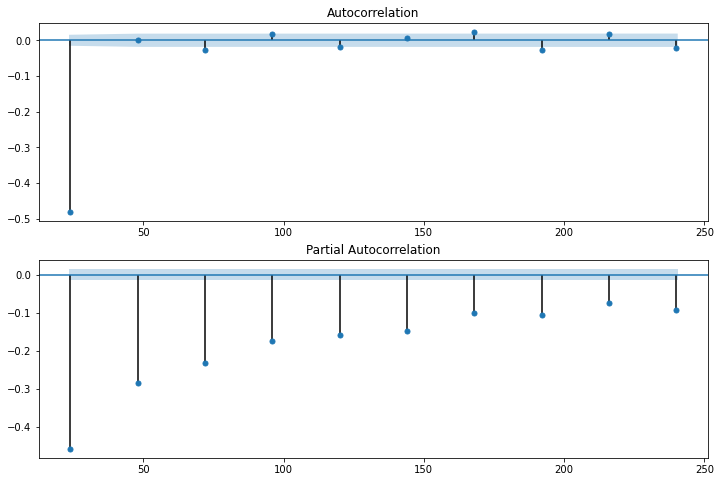

In [8]:
# Make a list of the first 10 seasonal lags
lags = [24, 48, 72, 96, 120, 144, 168, 192, 216, 240]
# finding P, Q
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# Make ACF plot 
plot_acf(power_2, lags=lags, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(power_2, lags=lags, zero=False, ax=ax2)
plt.show()

ACF: cut off after lag 1.

PACF: tails off.

$\therefore P=0, Q=1$
  
Based on the ACF and PACF plots

We get SARIMA(0,1,0)(0,1,1,24).

$$y^{\prime}_{t} = m_{24}\epsilon_{t-24} + \epsilon_{t} $$

# Fit models and narrow selection with AIC/BIC

In [9]:
# Instantiate model
model = SARIMAX(data['power(KWH)_replaced'], order=(0, 1, 0), seasonal_order=(0, 1, 1, 24))
# Fit model
results = model.fit()
# Print fit summary
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  power(KWH)_replaced   No. Observations:                17544
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 24)   Log Likelihood             -104242.184
Date:                              Thu, 16 Sep 2021   AIC                         208488.368
Time:                                      11:28:47   BIC                         208503.910
Sample:                                  01-01-2016   HQIC                        208493.486
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L24      -0.9638      0.002   -620.103      0.000      -0.967      -0.961
sigma2      8595.24

AIC and BIC 

AIC - Akaike information criterion. Lower AIC indicates a better model.

BIC - Bayesian information criterion. Lower BIC indicates a better model.

# Perform model diagnostics tests

Plot diagnostics.

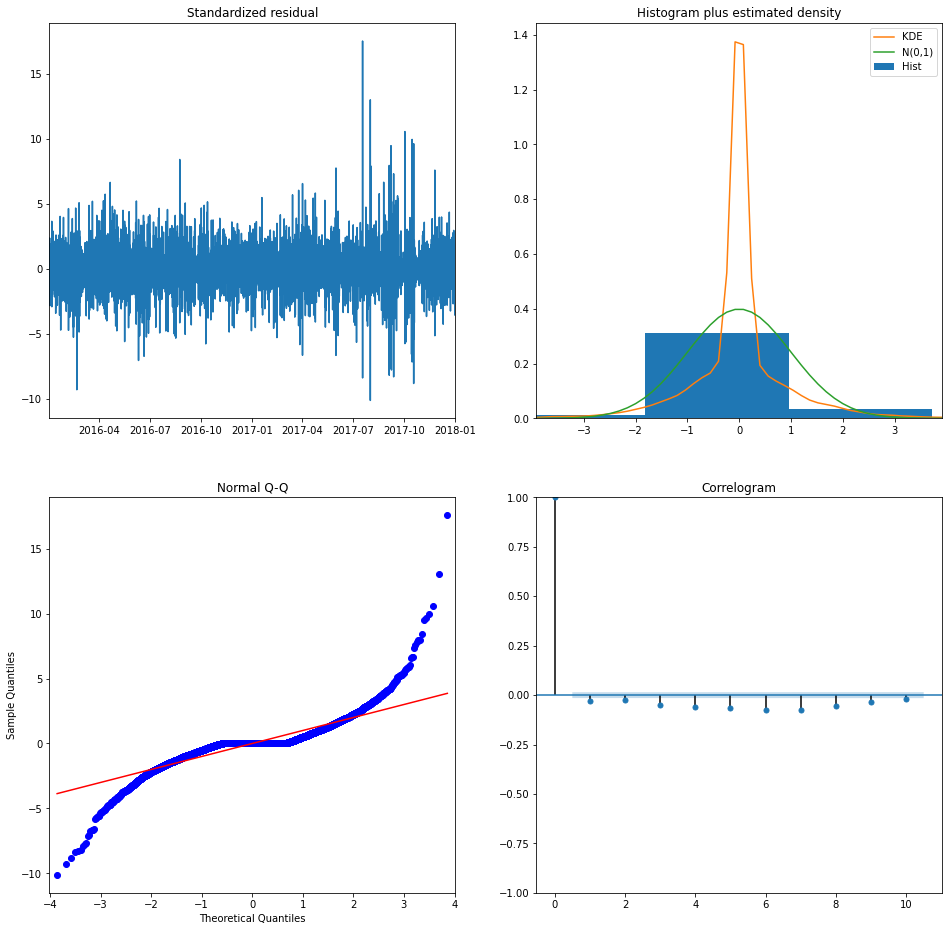

In [10]:
results.plot_diagnostics(figsize=(16,16))
plt.show()

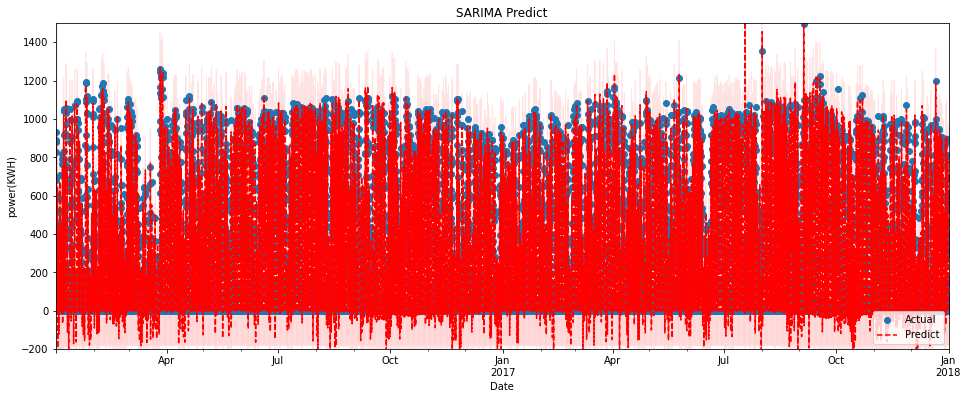

In [11]:
# predict
predict = results.get_prediction()
predict_ci = predict.conf_int()
# Graph
fig, ax = plt.subplots(figsize=(16,6))
npre = 4
ax.set(title='SARIMA Predict', xlabel='Date', ylabel='power(KWH)')

# Plot data points
data.loc['2016-01-01':, 'power(KWH)_replaced'].plot(ax=ax, style='o', label='Actual')

# Plot predictions
predict.predicted_mean.loc['2016-01-01':].plot(ax=ax, style='r--', label='Predict')
ci = predict_ci.loc['2016-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

ax.set_ylim(-200, 1500)
legend = ax.legend(loc='lower right')

Mean squared error:8636.0928


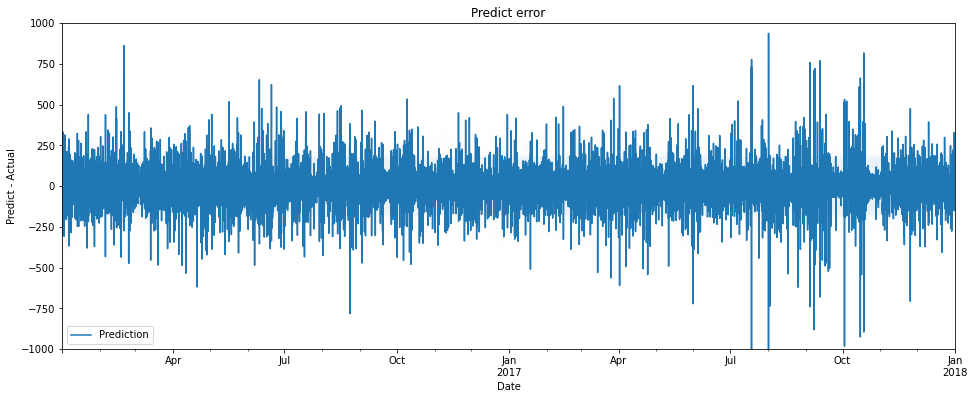

In [12]:
# Predict error 
# Graph
fig, ax = plt.subplots(figsize=(16,6))
npre = 4
ax.set(title='Predict error', xlabel='Date', ylabel='Predict - Actual')

# In-sample predict and 95% confidence intervals
predict_error = predict.predicted_mean - data.loc['2016-01-01':, 'power(KWH)_replaced']
predict_error.loc['2016-01-01':].plot(ax=ax, label='Prediction')
ci = predict_ci.loc['2016-01-01':].copy()
ci.iloc[:,0] -= data.loc['2016-01-01':, 'power(KWH)_replaced']
ci.iloc[:,1] -= data.loc['2016-01-01':, 'power(KWH)_replaced']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')
ax.set_ylim(-1000, 1000)
print('Mean squared error:{:.4f}'.format(mean_squared_error(data.loc[:, 'power(KWH)_replaced'], predict.predicted_mean)))

# Make forecasts

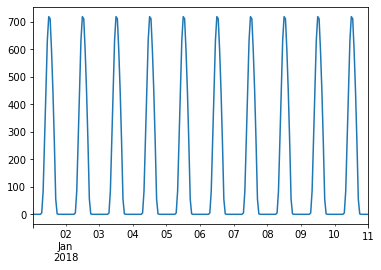

In [13]:
# forecast out of sample
forecast=results.forecast(steps=240)
forecast.plot()
plt.show()


SARIMA can't solve problem.

Try machine learning.